# In-lab data vs. Online data

### We want to understand if there is any difference in data quality between in-lab and online data. Past research has shwon in-lab data and online data are essentially the same in terms of data quality (Buhrmester et al., 2011; Gould et al., 2015; Reimers et al., 2015; Crump et al., 2013). But this is the first time, to our knowledge, that experiments framed in free-operant setting, were conducted online. Free-operant setting is special in the sense that nothing prompts the subjects to act. As such, subjects may respond at a rate of their own choosing within a given period of time, in either continuous or discrete manner. Futhermore, we require continuous engagement of subjects. 

### We use the following predictors:
* Latency by environment
* Environment

### Specifically, we want to answer these two questions:
First, is there evidence of a difference between in-lab data and online data?
<br>
Second, if so, which variables are responsible for these differences?

In [84]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
%matplotlib inline

In [85]:
#pip install mlxtend  

In [86]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [87]:
# import in-lab data and convert to panda dataframe
mat = sio.loadmat('untransformeddataforRN.mat', squeeze_me=True)
m = mat['untransformed_data']
in_lab = pd.DataFrame(m)
in_lab.columns = ['latency', 'price_displayed', 
             'id', 'price_bin', 'apathy', 'environment_binary']
#in_lab = in_lab[['latency', 'price_displayed', 'id', 'environment_binary']]

In [88]:
# add a label for all in_lab data
in_lab['label'] = [1]*len(in_lab)
in_lab.head(1)

,latency,price_displayed,id,price_bin,apathy,environment_binary,label
0,128.0,1.2,1.0,4.0,12.0,1.0,1


In [89]:
#import online data and add lables for all online data
online = pd.read_csv('fish_100.csv', sep = ",")
online['label'] = [0]*len(online)
online['environment_binary'] = np.where(online['environment']=='low', 0, online['environment'])
online['environment_binary'] = np.where(online['environment']=='high', 1, online['environment'])
online['environment_binary'] = np.where(online['environment']=='low', 0, online['environment_binary'])
online['environment_binary'] = np.where(online['environment']=='high', 1, online['environment_binary'])

In [91]:
online['latency'].describe()

count    317453.000000
mean        190.635020
std        1047.505729
min          79.000000
25%         149.000000
50%         172.000000
75%         197.000000
max      344778.000000
Name: latency, dtype: float64

In [75]:

online = online [['latency', 'price_displayed', 'id', 'environment_binary', 'label']]
online['latency'] = online.groupby(['id', 'environment', 'price_displayed']).



In [76]:
data = pd.concat([in_lab, online])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [77]:
#data = data.dropna()

In [78]:
data_model = data.groupby(['id', 'label', 'environment_binary'])['latency'].mean().reset_index(name = 'average_latency')



In [79]:
data_model=data_model[np.isfinite(data_model['average_latency'])]


In [99]:
data=data[np.isfinite(data['latency'])]


## Visualization 

In [100]:
in_lab_avg_latency = data[(data.label== 1)].latency
online_avg_latency = data[(data.label == 0)].latency


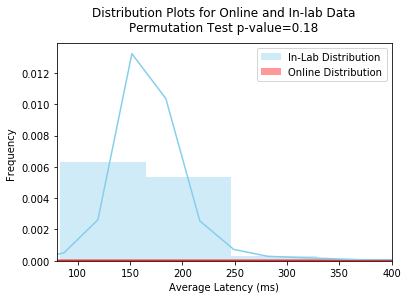

In [101]:
sns.distplot(in_lab_avg_latency , color="skyblue", label="In-Lab Distribution")
sns.distplot(online_avg_latency , color="red", label=r"Online Distribution")
plt.xlabel('Average Latency (ms)')
plt.ylabel('Frequency ')
plt.title(r'Distribution Plots for Online and In-lab Data'"\n"r'Permutation Test p-value=0.18', pad = 12)
plt.legend()
plt.xlim(80, 400)
#plt.annotate('Permutation Test p-value = 0.18', xy=(0.5, 0.03), xycoords='axes fraction', size = 'large')
plt.savefig('comparison.png', dpi = 300, transparent= True)
plt.show()

## Permutation Test

Null hypothesis: there is no difference between the two samples.
<br>Alternative hypothesis: the two samples are from two seperate distributions.

In [102]:
from mlxtend.evaluate import permutation_test

### Here we use the average latency as a measure, instead of the original values to avoid multiple comparison problems.

In [103]:
x = in_lab.groupby('id')['latency'].mean()
y = online.groupby('id')['latency'].mean()

Do NOT attempt 'exact' for permutation test. Our dataset is way too huge for all possible combination of data.

In [104]:
p_value = permutation_test(x, y,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)
print(p_value)

0.0333


## Split data

In [36]:
X = data_model[['average_latency', 'id', 'environment_binary']]
y = data_model['label']


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


## SVC

In [38]:
from sklearn.svm import SVC

In [39]:
#Support Vector Classifier
s_clf = SVC()
s_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [40]:
s_prediction = s_clf.predict(X_test)
print (s_prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [41]:
from sklearn.metrics import accuracy_score

In [42]:
s_acc = accuracy_score(s_prediction, y_test)
s_acc

0.8688524590163934

The model is guessing in this case; There are 21 in lab participants and 100 (100/121 = 0.82) online subjects.
Due to such imbalance of classes, the model can always guess 0 (the predominant one) and get above chance.

Classifier quality measures like area under the ROC curve (AUC) can be used to assess the degree of difference between the original datasets: small AUC values suggest that the original datasets are similar, while large AUC values suggest substantial differences. 

In [43]:
from sklearn.metrics import roc_curve, auc

In [44]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, s_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

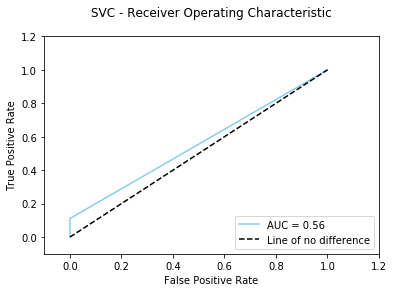

In [64]:
plt.title('SVC - Receiver Operating Characteristic', pad = 20)
plt.plot(false_positive_rate, true_positive_rate, 'skyblue',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label = 'Line of no difference', color = 'black')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('svc.png', transparent = True, dpi = 300)
plt.show()

## Classifer Comparison (for very strict standard) 

In [26]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [27]:
names = ["Linear SVM",
         "Decision Tree", "Random Forest", "Neural Net",
         "Naive Bayes"]

In [28]:
s_clf = SVC()
s_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Random Forest Classifier

In [29]:
clf_randomforest = RandomForestClassifier(n_estimators=1, max_depth=2,random_state=0)

In [30]:
clf_randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
randomforest_prediction = clf_randomforest.predict(X_test)

In [32]:
randomforest_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [33]:
randomforest_acc = accuracy_score(randomforest_prediction, y_test)
randomforest_acc

0.8524590163934426

In [34]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, randomforest_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

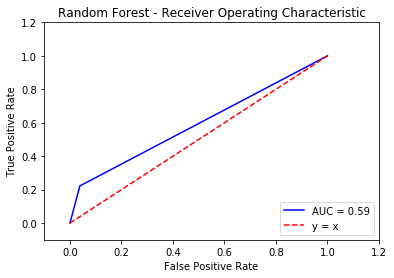

In [35]:
plt.title('Random Forest - Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label = 'y = x')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Neural Net

In [78]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test) 

In [97]:
clf_neuralnet = MLPClassifier(solver='sgd', alpha=0.0001,hidden_layer_sizes=(5, 2), random_state=0)

In [98]:
clf_neuralnet.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [99]:
neuralnet_prediction = clf_neuralnet.predict(X_test)
neuralnet_acc = accuracy_score(neuralnet_prediction, y_test)
neuralnet_acc

0.8524590163934426

In [100]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, neuralnet_prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

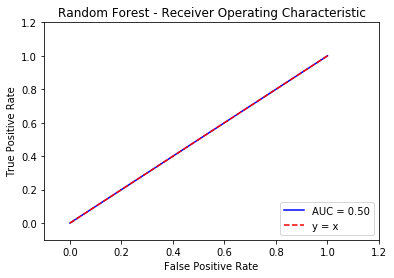

In [101]:
plt.title('Neural Net - Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label = 'y = x')
plt.legend(loc='lower right')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()